# Neural Network

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, roc_auc_score
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
from hotel_preprocessing import clean_data, extract_features, drop_columns, XYPreprocessor

# Load dataset
df = pd.read_csv("hotel_bookings.csv")  # alr scaled, clean data
hotel = df.copy()


In [2]:
hotel.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,No Deposit,NaN,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,No Deposit,304.0,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,No Deposit,240.0,NaN,0,Transient,98.0,0,1,Check-Out,2015-07-03


# Stage 1 - Predict Cancel/ Not

## Split Data into Training, Test (Time-based holdout)

In [3]:
# Combine year, month, and day columns into a single datetime column
hotel['arrival_date'] = pd.to_datetime(
    hotel['arrival_date_year'].astype(str) + '-' +
    hotel['arrival_date_month'] + '-' +
    hotel['arrival_date_day_of_month'].astype(str),
    format='%Y-%B-%d'  # Ensure proper month name parsing
)

# Determine the latest arrival date
last_date = hotel['arrival_date'].max()

# Define the cutoff date for the last 3 months
cutoff_date = last_date - pd.DateOffset(months=3)

# Split by cutoff date
test_data = hotel[hotel['arrival_date'] > cutoff_date].reset_index(drop=True)
train_val_data = hotel[hotel['arrival_date'] <= cutoff_date].reset_index(drop=True)

# Separate raw features and labels
X_train_val_raw = train_val_data.drop(columns=['is_canceled'])
y_train_val_raw = train_val_data['is_canceled'].astype(int)

X_test_raw = test_data.drop(columns=['is_canceled'])
y_test_raw = test_data['is_canceled'].astype(int)



## Preprocess + Clean data

In [4]:
# Preprocess train_val once, then split into folds
preprocessor = XYPreprocessor()
X_train_val, y_train_val = preprocessor.fit_transform(X_train_val_raw, y_train_val_raw)

# Transform test set using the same preprocessor
X_test, y_test = preprocessor.transform(X_test_raw, y_test_raw)

# print the shapes of the datasets
print(f"X_train: {X_train_val.shape}, X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train_val.shape}, y_test shape: {y_test.shape}")

X_train: (74216, 99), X_test shape: (13161, 99)
y_train shape: (74216,), y_test shape: (13161,)


## Model Training

In [5]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score, accuracy_score
import optuna

# --- Neural Network Definition ---
class CancellationNet(nn.Module):
    def __init__(self, input_dim, hidden_dim=128, dropout=0.3):
        super(CancellationNet, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),   # Input layer with 128 neurons
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),  # ELU might be overkill since rather shallow network
            nn.Dropout(dropout),    # Randomly zeroes out 30% of activations during training to prevent overfitting

            nn.Linear(hidden_dim, hidden_dim // 2), # Compresses feature map to half size (from 128 → 64)
            nn.BatchNorm1d(hidden_dim // 2),
            nn.ReLU(),
            nn.Dropout(dropout / 2),    # less dropout in the second layer to retain more information

            nn.Linear(hidden_dim // 2, 1),  # Output layer with 1 neuron for binary classification
            nn.Sigmoid()  # Needed for binary classification output
        )

    def forward(self, x):
        return self.model(x).squeeze()



In [6]:
# --- Training Function ---
def train_model(X, y, params, device):
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)    # 5-fold cross-validation
    val_aucs = []

    for train_idx, val_idx in skf.split(X, y):
        X_tr, X_val = X[train_idx], X[val_idx]
        y_tr, y_val = y[train_idx], y[val_idx]

        model = CancellationNet(X.shape[1], params['hidden_dim'], params['dropout']).to(device)
        criterion = nn.BCELoss()
        optimizer = torch.optim.AdamW(model.parameters(), lr=params['lr'], weight_decay=1e-4)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=2, factor=0.5)

        train_loader = DataLoader(TensorDataset(X_tr, y_tr), batch_size=params['batch_size'], shuffle=True)

        best_auc = 0
        patience = 3
        counter = 0

        for epoch in range(params['epochs']):
            model.train()
            for xb, yb in train_loader:
                xb, yb = xb.to(device), yb.to(device)
                optimizer.zero_grad()
                preds = model(xb)
                loss = criterion(preds, yb)
                loss.backward()
                optimizer.step()

            model.eval()
            with torch.no_grad():
                val_preds = model(X_val.to(device)).cpu().numpy()
                auc = roc_auc_score(y_val.numpy(), val_preds)
                scheduler.step(auc)

                if auc > best_auc:
                    best_auc = auc
                    counter = 0
                else:
                    counter += 1

            if counter >= patience:
                break

        val_aucs.append(best_auc)

    return np.mean(val_aucs)

In [7]:
X_train_tensor = torch.tensor(X_train_val.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_val.values, dtype=torch.float32)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [8]:
# --- Optuna Objective Function ---
def objective(trial):
    params = {
        'hidden_dim': trial.suggest_categorical('hidden_dim', [64, 128, 256]),
        'dropout': trial.suggest_float('dropout', 0.2, 0.5),
        'lr': trial.suggest_float('lr', 1e-5, 1e-2, log=True),
        'batch_size': trial.suggest_categorical('batch_size', [32, 64, 128]),
        'epochs': trial.suggest_int('epochs', 5, 15)
    }
    return train_model(X_train_tensor, y_train_tensor, params, device)

# --- Run Hyperparameter Tuning ---
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=20)

best_params = study.best_trial.params
print("\n✅ Best Validation AUC: {:.4f}".format(study.best_value))
print("Best Hyperparameters:")
for k, v in best_params.items():
    print(f"  {k}: {v}")

[I 2025-06-22 22:31:12,664] A new study created in memory with name: no-name-b459797e-6a57-4e90-9bd5-4f45b18a614e
[I 2025-06-22 22:31:45,473] Trial 0 finished with value: 0.886081571323128 and parameters: {'hidden_dim': 128, 'dropout': 0.32305754893261707, 'lr': 7.107412082018802e-05, 'batch_size': 128, 'epochs': 5}. Best is trial 0 with value: 0.886081571323128.
[I 2025-06-22 22:33:14,812] Trial 1 finished with value: 0.9065755487928124 and parameters: {'hidden_dim': 256, 'dropout': 0.4025019286528737, 'lr': 0.0001444255518645011, 'batch_size': 32, 'epochs': 5}. Best is trial 1 with value: 0.9065755487928124.
[I 2025-06-22 22:34:53,272] Trial 2 finished with value: 0.9177566970763376 and parameters: {'hidden_dim': 256, 'dropout': 0.3188955463797389, 'lr': 0.0010760734561471362, 'batch_size': 64, 'epochs': 9}. Best is trial 2 with value: 0.9177566970763376.
[I 2025-06-22 22:35:42,356] Trial 3 finished with value: 0.9157599251136228 and parameters: {'hidden_dim': 128, 'dropout': 0.40067


✅ Best Validation AUC: 0.9192
Best Hyperparameters:
  hidden_dim: 256
  dropout: 0.25773165057928665
  lr: 0.0005095424793910066
  batch_size: 128
  epochs: 12


In [9]:
import torch.nn.functional as F

# --- Final Training on Full Training Set ---
final_model = CancellationNet(X_train_tensor.shape[1], best_params['hidden_dim'], best_params['dropout']).to(device)
optimizer = torch.optim.AdamW(final_model.parameters(), lr=best_params['lr'], weight_decay=1e-4)
criterion = nn.BCELoss()

train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=best_params['batch_size'], shuffle=True)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)

final_model.train()
for epoch in range(best_params['epochs']):
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        preds = final_model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()
        
# save best model
torch.save({
    'model_state_dict': final_model.state_dict(),
    'model_hyperparams': best_params
}, "best_nn_model_full.pth")

In [ ]:
import shap
import torch

def get_top_feature_importances(model, feature_names, X_background, X_explain, top_n=5):
    """
    Computes and returns top N feature importances using SHAP values.

    Args:
        model (nn.Module): Trained PyTorch model (CancellationNet).
        feature_names (list): Names of features (column names).
        X_background (np.ndarray): Background dataset for SHAP.
        X_explain (np.ndarray): Sample data to explain.
        top_n (int): Number of top features to return.

    Returns:
        pd.DataFrame: Top N features and their SHAP importance scores.
    """
    model.eval()    # disables dropout and batchnorm noise
    # if don't use .eval --> SHAP explanations may be noisy, unstable, and hard to reproduce
    # if don't use .eval --> Feature attributions can fluctuate across runs
    # dropout doesn't work in eval mode, so it will not randomly zero out activations, it is only used during training to prevent overfitting
    

    # Wrap model into a callable for SHAP
    def model_forward(x_np):
        x_tensor = torch.tensor(x_np, dtype=torch.float32).to(next(model.parameters()).device)
        with torch.no_grad():
            preds = model(x_tensor).cpu().numpy()
        return preds

    # Use KernelExplainer for model-agnostic SHAP values
    explainer = shap.Explainer(model_forward, X_background)
    shap_values = explainer(X_explain)

    # Mean absolute SHAP value per feature
    feature_importance = np.abs(shap_values.values).mean(axis=0)

    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'SHAP_Importance': feature_importance
    }).sort_values(by='SHAP_Importance', ascending=False)

    return importance_df.head(top_n)

top_features_df = get_top_feature_importances(
    model=final_model,
    feature_names=X_train_val.columns.tolist(),
    X_background=X_train_val.values[:100],   # scaled NumPy array
    X_explain=X_test[:50],            # scaled NumPy array
    top_n=5
)

print("\n🔍 Top 5 Most Important Features (SHAP):")
print(top_features_df.to_string(index=False))


PermutationExplainer explainer: 51it [00:12,  4.02it/s]                        


🔍 Top 5 Most Important Features (SHAP):
                  Feature  SHAP_Importance
        arrival_date_year         0.267825
       country_binned_PRT         0.094420
total_of_special_requests         0.079548
            lead_time_log         0.074894
       agent_binned_Other         0.045582


## Test Model

In [11]:
# --- Evaluate on Test Set ---
final_model.eval()
with torch.no_grad():
    test_preds = final_model(X_test_tensor.to(device)).cpu().numpy()
    test_binary = (test_preds >= 0.5).astype(int)
    y_true = y_test_tensor.cpu().numpy()

# --- Evaluation Metrics ---
test_auc = roc_auc_score(y_true, test_preds)
acc = accuracy_score(y_true, test_binary)
prec = precision_score(y_true, test_binary)
rec = recall_score(y_true, test_binary)
f1 = f1_score(y_true, test_binary)

print("\n📊 Final Test Set Evaluation:")
print(f"AUC:       {test_auc:.4f}")
print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall:    {rec:.4f}")
print(f"F1 Score:  {f1:.4f}")


📊 Final Test Set Evaluation:
AUC:       0.8645
Accuracy:  0.7845
Precision: 0.7078
Recall:    0.6642
F1 Score:  0.6853


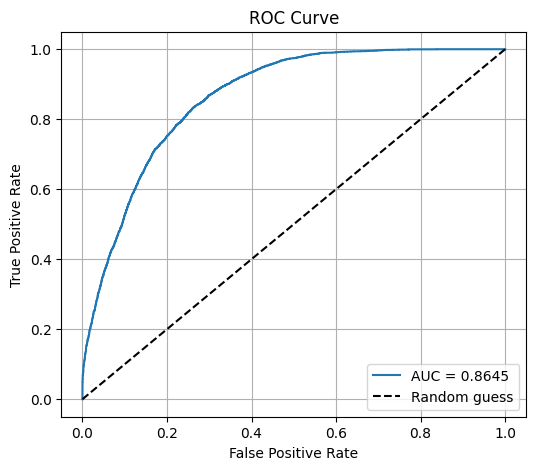

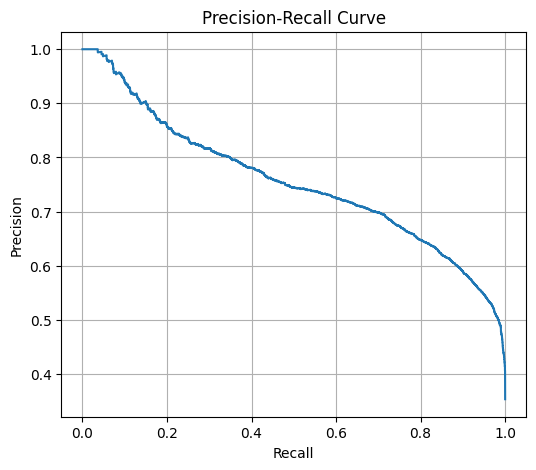

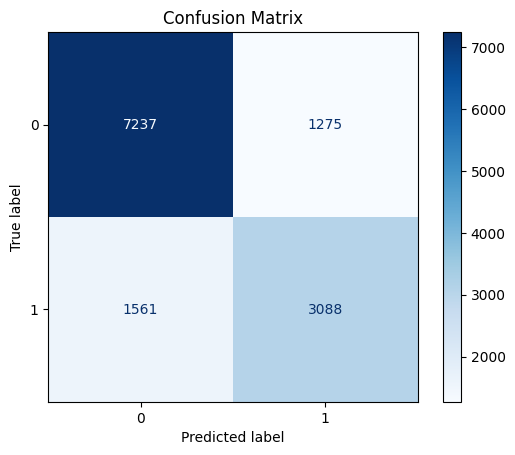

In [12]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, precision_recall_curve, confusion_matrix, ConfusionMatrixDisplay

# --- Plot ROC Curve ---
fpr, tpr, _ = roc_curve(y_true, test_preds)
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f'AUC = {test_auc:.4f}')
plt.plot([0, 1], [0, 1], 'k--', label='Random guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# --- Plot Precision-Recall Curve ---
precision, recall, _ = precision_recall_curve(y_true, test_preds)
plt.figure(figsize=(6, 5))
plt.plot(recall, precision, label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.grid(True)
plt.show()

# --- Plot Confusion Matrix ---
cm = confusion_matrix(y_true, test_binary)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()